In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import os, sys
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm.notebook import tqdm
import joblib 
import re

# if parent 'Toybrains' directory is not in path, add it
if os.path.abspath('../../') not in sys.path:
    sys.path.append(os.path.abspath('../../'))

from create_toybrains import ToyBrainsData
from utils.vizutils import *
from utils.configutils import *

### Config

In [3]:
N_SAMPLES  = 5000
basefilename = 'lblmidr-consite'
datasets = glob(f"dataset/*n{N_SAMPLES}_*{basefilename}*/")

In [4]:
print("available baseline results:")
run_files = pd.DataFrame([f.split('/')[-3:-1] for f in glob(f'dataset/toybrains_n{N_SAMPLES}_{basefilename}*/baseline_results/*/*/run.csv')])
if len(run_files.columns): run_files.columns = ['Model', 'Params']
run_files.value_counts()

available baseline results:


Model  Params                           
LR     penalty-l1-c-1-0-solver-liblinear    125
RF     default                              125
SVM    kernel-linear                        125
LR     default                              117
MLP    default                               94
SVM    default                               31
Name: count, dtype: int64

In [5]:
# notebook chapters to run
MODEL_NAME = 'RF'
MODEL_PARAMS = 'default' #{'kernel': 'rbf'},  penalty-l1-c-1-0-solver-liblinear
GEN_BASELINE = False
COMPUTE_SHAP = False

SHOW_RESULTS_TABLE = False
PLOT_MODEL_CONTRIB = False
PLOT_SHAP_CONTRIB = False

metric_name = 'balanced_accuracy' # 'balanced_accuracy', 'r2', 'adjusted_mutual_info_score'
PLOT_CONTRIB_DECOMPOSED = True    
SAVE_FIGS = False                

### Load the baseline results

In [6]:
### for each dataset find the holdout data that are (a) an equivalent dataset with no conf signal and (b) an equivalent dataset with no true signal 
dataset_tuples = []
test_suffix = '_test'
test_nsamples = 1000

for dataset in datasets:
    dataset = dataset.rstrip('/')
    dataset_test = re.sub(f'_n{N_SAMPLES}_', f'_n{test_nsamples}_', dataset) + test_suffix
    dataset_noconf = re.sub('cX...', 'cX000', re.sub('cy...','cy000', dataset_test))
    assert os.path.exists(dataset_noconf), f"Could not find noconf dataset {dataset_noconf} for {dataset}"
    # also force the Xy relation to be the max
    dataset_noconf_ext = re.sub('yX...', 'yX100', dataset_noconf)
    assert os.path.exists(dataset_noconf_ext), f"Could not find noconf dataset {dataset_noconf_ext} for {dataset}"

    dataset_nosignal = re.sub('yX...','yX000', dataset_test) 
    assert os.path.exists(dataset_nosignal), f"Could not find nosignal dataset {dataset_nosignal} for {dataset}"
    # also force the X<-c->y relation to be the max
    dataset_nosignal_ext = re.sub('cX...', 'cX100', re.sub('cy...','cy100', dataset_nosignal))
    assert os.path.exists(dataset_nosignal_ext), f"Could not find nosignal dataset {dataset_nosignal_ext} for {dataset}"
    
    dataset_tuples.append((dataset, 
                            {'no-conf': dataset_noconf, 'no-conf_ext': dataset_noconf_ext,
                             'no-true': dataset_nosignal, 'no-true_ext': dataset_nosignal_ext}))

In [7]:
dataset_tuples

[('dataset/toybrains_n5000_lblmidr-consite_cy025-cX025-yX100',
  {'no-conf': 'dataset/toybrains_n1000_lblmidr-consite_cy000-cX000-yX100_test',
   'no-conf_ext': 'dataset/toybrains_n1000_lblmidr-consite_cy000-cX000-yX100_test',
   'no-true': 'dataset/toybrains_n1000_lblmidr-consite_cy025-cX025-yX000_test',
   'no-true_ext': 'dataset/toybrains_n1000_lblmidr-consite_cy100-cX100-yX000_test'}),
 ('dataset/toybrains_n5000_lblmidr-consite_cy000-cX075-yX100',
  {'no-conf': 'dataset/toybrains_n1000_lblmidr-consite_cy000-cX000-yX100_test',
   'no-conf_ext': 'dataset/toybrains_n1000_lblmidr-consite_cy000-cX000-yX100_test',
   'no-true': 'dataset/toybrains_n1000_lblmidr-consite_cy000-cX075-yX000_test',
   'no-true_ext': 'dataset/toybrains_n1000_lblmidr-consite_cy100-cX100-yX000_test'}),
 ('dataset/toybrains_n5000_lblmidr-consite_cy050-cX075-yX000',
  {'no-conf': 'dataset/toybrains_n1000_lblmidr-consite_cy000-cX000-yX000_test',
   'no-conf_ext': 'dataset/toybrains_n1000_lblmidr-consite_cy000-cX000-

In [8]:
# ! rm -rvf dataset/toybrains_n10000_lblmidr-consite_*/baseline_results/*

In [9]:
def generate_baseline_results(dataset, holdout_data=None,
                              input_feature_sets=["attr_all", "attr_subsets", "cov_all"],
                              output_labels=["lbls"], 
                              model_name='LR', model_params={},
                              metrics=['r2'],
                              compute_shap=True,
                              n_trials=5, n_samples=1000, verbose=0):    
    # get the related config file
    dataset_unique_id = dataset.rstrip('/').split('/')[-1].split(f'n{n_samples}_')[-1]
    config_file = glob(f"configs/*{dataset_unique_id}*.py")
    assert len(config_file)==1, f"couldn't find the config file used to generate the dataset with unique ID '{dataset_unique_id}'. \nFound {config_file}"
    config_file = config_file[0]

    # init the ToyBrainsData instance
    toy = ToyBrainsData(config=config_file)
    toy.load_generated_dataset(dataset)
    bl_result = toy.fit_contrib_estimators(
            input_feature_sets=input_feature_sets,
            output_labels=output_labels, 
            model_name=model_name, model_params=model_params,
            holdout_data=holdout_data,
            compute_shap=compute_shap,
            outer_CV=n_trials, inner_CV=5,
            metrics=metrics,
            debug=False,
            verbose=verbose)
    
    return bl_result

# test case
# dfi = generate_baseline_results(dataset_tuples[0][0], holdout_data=dataset_tuples[0][1], 
#                                 input_feature_sets=["attr_all"], 
#                                 output_labels=["lbls"],
#                                 metrics=['balanced_accuracy', 'r2', 'roc_auc'], n_trials=2, 
#                                 model_name=MODEL_NAME, model_params=MODEL_PARAMS,
#                                 compute_shap=COMPUTE_SHAP,
#                                 n_samples=N_SAMPLES, verbose=2)
# dfi

In [10]:
# ! rm -rvf dataset/toybrains_n10000_lblmidr-consite_*/baseline_results/*

##### If baseline results are already generated, load them

In [11]:
# just load the baseline results if they were already generated
if not GEN_BASELINE:
    bl_results = []
    for dataset in datasets:
        if not isinstance(MODEL_PARAMS, str):
            MODEL_PARAMS = ToyBrainsData.get_model_params_str(MODEL_PARAMS)
        results_file = f"{dataset}baseline_results/{MODEL_NAME}/{MODEL_PARAMS}/run.csv"
        if os.path.exists(results_file):
            df = pd.read_csv(results_file)
            bl_results.append(df)
        else:
            print(f"[WARN] Could not find baseline results for dataset {dataset}")

    print(f"Loaded {len(bl_results)} baseline results")

Loaded 125 baseline results


#### Otherwise, we will regenerate the baseline results

##### Otherwise, generate baseline results

In [12]:
#  generate the baseline results on generated datasets using parallel processes
if GEN_BASELINE:
    bl_results = joblib.Parallel(n_jobs=-1)(
        joblib.delayed(
            generate_baseline_results)(
                dataset, holdout_data=holdout_data,
                input_feature_sets=["attr_all", "attr_subsets", "cov_all"], 
                output_labels=["lbls"],
                compute_shap=COMPUTE_SHAP,
                metrics=['balanced_accuracy', 'r2', 'roc_auc'], n_trials=5, 
                n_samples=N_SAMPLES, verbose=0) for dataset, holdout_data in tqdm(dataset_tuples))
                

### See the table

In [13]:
non_shap_cols = bl_results[0].filter(regex="^((?!shap__).)*$").columns
print("Total result tables generated = {}.\n\
shape of each results tables = {}.\n\
Columns in the baseline results: {}  (and n={} shap contrib scores).\n\
Columns = {}".format(len(bl_results), bl_results[0].shape, 
                     len(non_shap_cols), len(bl_results[0].columns)-len(non_shap_cols),
                     non_shap_cols))

Total result tables generated = 125.
shape of each results tables = (25, 38).
Columns in the baseline results: 38  (and n=0 shap contrib scores).
Columns = Index(['dataset', 'out', 'inp', 'trial', 'model', 'type',
       'score_train_balanced_accuracy', 'score_test_balanced_accuracy',
       'score_test_no-conf_balanced_accuracy',
       'score_test_no-conf_ext_balanced_accuracy',
       'score_test_no-true_balanced_accuracy',
       'score_test_no-true_ext_balanced_accuracy', 'score_train_r2',
       'score_test_r2', 'score_test_no-conf_r2', 'score_test_no-conf_ext_r2',
       'score_test_no-true_r2', 'score_test_no-true_ext_r2',
       'score_train_roc_auc', 'score_test_roc_auc',
       'score_test_no-conf_roc_auc', 'score_test_no-conf_ext_roc_auc',
       'score_test_no-true_roc_auc', 'score_test_no-true_ext_roc_auc',
       'score_train_adjusted_mutual_info_score',
       'score_test_adjusted_mutual_info_score',
       'score_test_no-conf_adjusted_mutual_info_score',
       'score_

In [14]:
if SHOW_RESULTS_TABLE:
    show_contrib_table(bl_results)


### Viz the baseline contrib scores

In [15]:
# filter specific rows and columns from the table
df_model = show_contrib_table(
                bl_results, 
                avg_over_trials=False,
                filter_rows={'out':['lbl_lesion']}, 
                filter_cols=['score_test_r2']
                )
# df_model

All results are shown in percentage (%)


#### Model-based contrib scores

In [16]:
if PLOT_MODEL_CONTRIB:
    viz_contrib_table(df_model, X_axes=['c->y','X->y'],
                        metric_col='score_test_r2',
                        show_SHAP=False, err_style='bars',
                        y_label_suffix='(pseudo R2)')

### SHAP-based contrib scores

In [17]:
if PLOT_SHAP_CONTRIB:
    # look at the SHAP values
    df_shap = show_contrib_table(
                    bl_results, 
                    avg_over_trials=False,
                    filter_rows={'out':['lbl_lesion']},
                    filter_cols=['score_test_r2', 
                                    'shap__shape-midr_curv','shap__shape-midr_vol-rad', 
                                    'shap__brain-int_fill'])
    
    # display(df_shap)
    viz_contrib_table(df_shap, X_axes=['c->y','X->y'], 
                  show_SHAP=True, err_style='bars')

### Compare the performance on noConf and noTrue test data

In [18]:
# remap the default MODEL_PARAMS tag to the exact default model parameters settings
if MODEL_NAME=='LR' and MODEL_PARAMS=='default':
    MODEL_PARAMS = 'penalty-l2'
elif MODEL_NAME=='SVM' and MODEL_PARAMS=='default':
    MODEL_PARAMS = 'kernel-RBF'
elif MODEL_NAME=='RF' and MODEL_PARAMS=='default':
    MODEL_PARAMS = 'n_estimators-200'
elif MODEL_NAME=='MLP' and MODEL_PARAMS=='default':
    MODEL_PARAMS = 'layers-[5000][200][50]'

In [19]:
if SAVE_FIGS:
    ! rm -rvf figures/*_${MODEL_NAME}_${MODEL_PARAMS}_${metric_name}*
    ! mkdir -p figures

All results are shown in percentage (%)


All results are shown in percentage (%)
All results are shown in percentage (%)


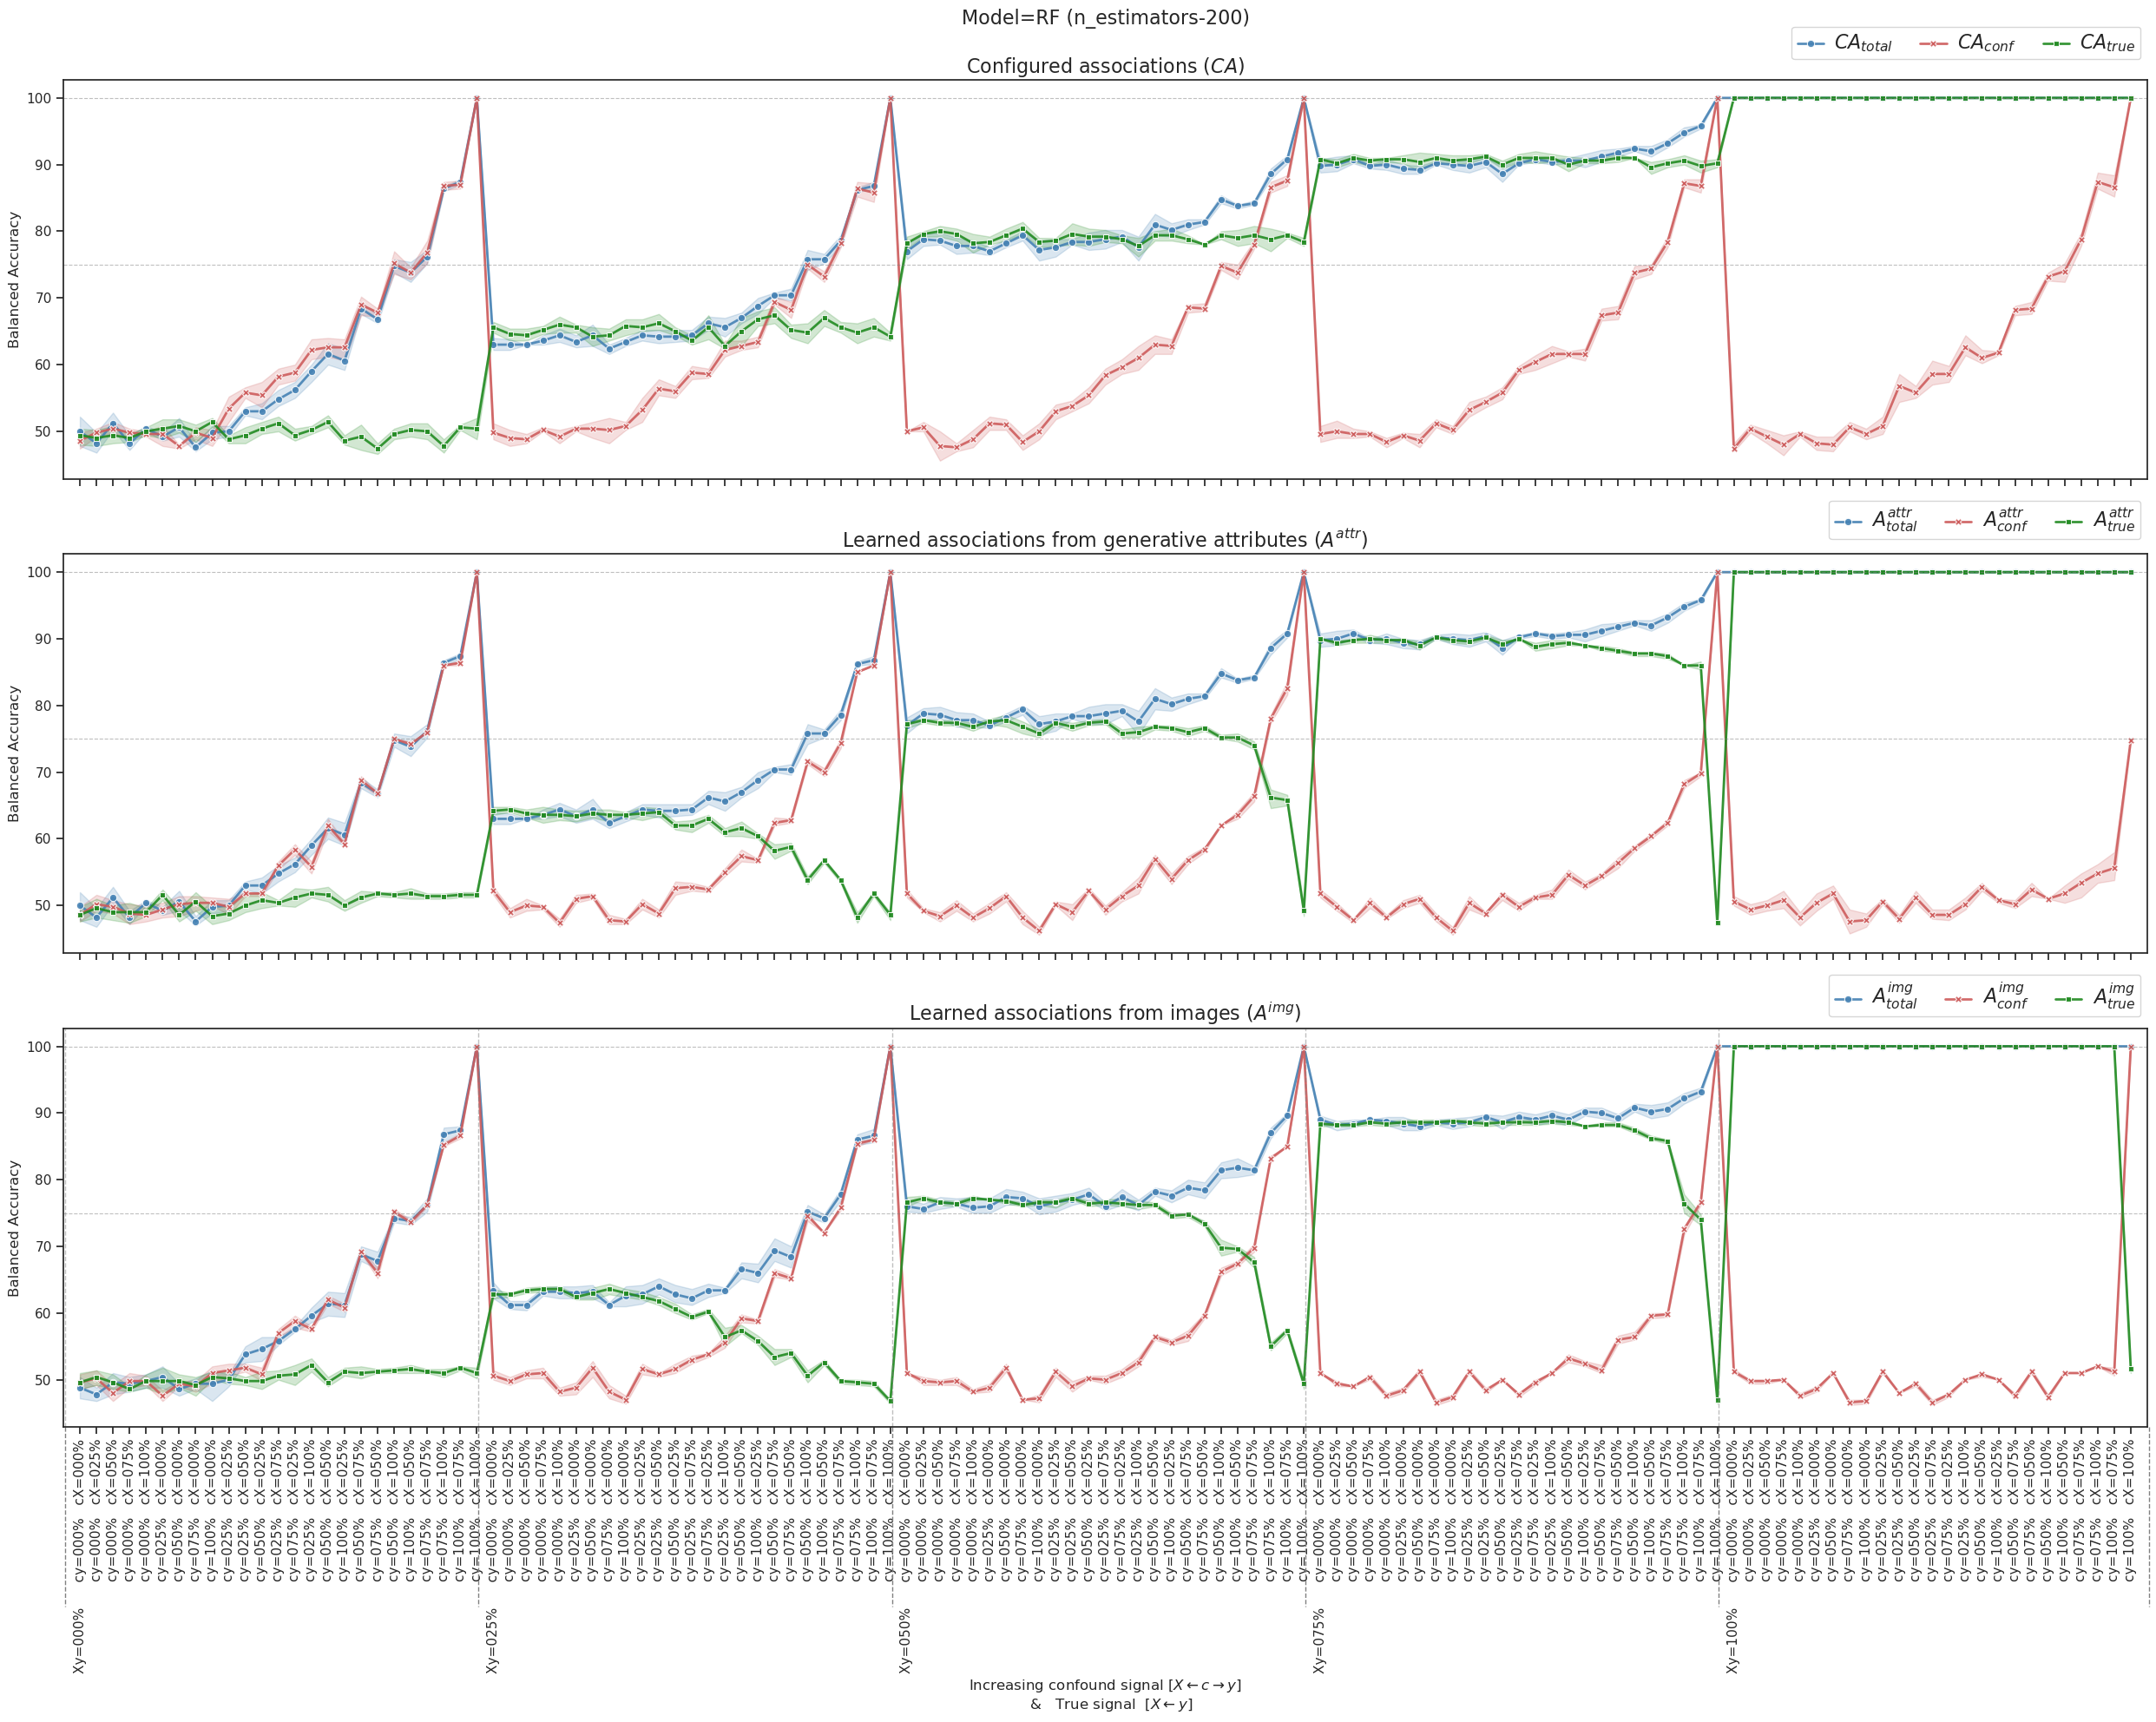

In [22]:
if PLOT_CONTRIB_DECOMPOSED:

    sns.set_theme(style="ticks")
    f, axes = plt.subplots(3, 1, figsize=(25, 20), sharex=True, sharey=True)
    axes = axes.flatten()

    df_model = show_contrib_table(
                bl_results, 
                avg_over_trials=False, 
                filter_rows={'out':['lbl_lesion'], 
                'inp':['attr_all', 'attr_brain-int_fill', 'attr_shape-midr_curv, shape-midr_vol-rad']},
                filter_cols=[f'score_test_{metric_name}']
                )
    df_model = df_model.data.unstack(level='inp').reset_index(level=["out", "trial"], drop=True)
    # drop the top level of the column index
    df_model.columns = df_model.columns.droplevel()
    # df_model = df_model.drop_leve(columns=['score_test_r2'])
    # display(df_model.head())    
    df_model = df_model.rename(columns={'attr_all': r'$CA_{total}$', 
                                        'attr_brain-int_fill':r'$CA_{conf}$', 
                                        'attr_shape-midr_curv, shape-midr_vol-rad':r'$CA_{true}$'})
    
    viz_contrib_table_2(df_model, metric_name=metric_name, 
                        ax=axes[0], adjust_xticks=False,
                        cmap={r'$CA_{total}$':'steelblue',
                              r'$CA_{conf}$':'indianred',
                              r'$CA_{true}$':'forestgreen'},
                        title=f'Model={MODEL_NAME} ({MODEL_PARAMS})\n\n'+r"Configured associations ($CA$)")
    

    # plot the decomposed contributions
    df_decomp = show_contrib_table(
                   bl_results, 
                   avg_over_trials=False, 
                   filter_rows={'out':['lbl_lesion'], 'inp':['attr_all']},
                   filter_cols=[f'score_test_{metric_name}', 
                                f'score_test_no-conf_{metric_name}', 
                                f'score_test_no-true_{metric_name}']
                                )
    
    df_decomp = df_decomp.data.rename(columns={f'score_test_{metric_name}':'conf & true',
                                               f'score_test_no-conf_{metric_name}':'true',
                                               f'score_test_no-true_{metric_name}':'conf'})
    
    # if the r2 metric values are below 0 then set it to zero
    if metric_name=='r2':
        df_decomp[['conf & true', 'true', 'conf']] = df_decomp[['conf & true','true', 'conf']].map(lambda x: 0 if x<0 else x)
    # display(df_decomp.style.bar( align='mid', color=['#d65f5f', '#5fba7d']))
        
    df_decomp_plot = df_decomp.reset_index(level=["out", "inp", "trial"], drop=True)
    df_decomp_plot.index = df.index.map(lambda x: x.split('_')[-1])  # remove the 'dataset' prefix
    df_decomp_plot = df_decomp_plot.rename(columns={'conf & true':r'$A^{attr}_{total}$', 
                                                    'true':r'$A^{attr}_{true}$',  #'( conf & true ) - ( conf )'
                                                    'conf':r'$A^{attr}_{conf}$'}  #'( conf & true ) - ( true )'
                                                    )
    # reorder columns so that Aconf is red and Atrue is green
    df_decomp_plot = df_decomp_plot[[r'$A^{attr}_{total}$', r'$A^{attr}_{conf}$', r'$A^{attr}_{true}$']]
    viz_contrib_table_2(df_decomp_plot, metric_name=metric_name, 
                        ax=axes[1], adjust_xticks=False,
                        cmap={r'$A^{attr}_{total}$':'steelblue',
                              r'$A^{attr}_{conf}$':'indianred',
                              r'$A^{attr}_{true}$':'forestgreen'},
                        title=r"Learned associations from generative attributes ($A^{attr}$)")
        

    ### plot the decomposed contributions
    df_imgs = show_contrib_table(
                   bl_results, 
                   avg_over_trials=False,
                   filter_rows={'out':['lbl_lesion'], 'inp':['images']},
                   filter_cols=[f'score_test_{metric_name}', 
                                f'score_test_no-conf_{metric_name}', 
                                f'score_test_no-true_{metric_name}']
                                )
    
    df_imgs = df_imgs.data.rename(columns={f'score_test_{metric_name}':'conf & true',
                                               f'score_test_no-conf_{metric_name}':'true',
                                               f'score_test_no-true_{metric_name}':'conf'})
    
    # if the r2 metric values are below 0 then set it to zero
    if metric_name=='r2':
        df_imgs[['conf & true', 'true', 'conf']] = df_imgs[['conf & true','true', 'conf']].map(lambda x: 0 if x<0 else x)
    
    
    df_imgs_plot = df_imgs.reset_index(level=["out", "inp", "trial"], drop=True)
    df_imgs_plot.index = df_imgs_plot.index.map(lambda x: x.split('_')[-1])  # remove the 'dataset' prefix
    df_imgs_plot = df_imgs_plot.rename(columns={'conf & true':r'$A^{img}_{total}$', 
                                                'true':r'$A^{img}_{true}$', 
                                                'conf':r'$A^{img}_{conf}$'})
    
    # reorder columns so that Aconf is red and Atrue is green
    df_imgs_plot = df_imgs_plot[[r'$A^{img}_{total}$', r'$A^{img}_{conf}$', r'$A^{img}_{true}$']]
    viz_contrib_table_2(df_imgs_plot, metric_name=metric_name, 
                        ax=axes[2], adjust_xticks=True,
                        cmap={r'$A^{img}_{total}$':'steelblue',
                              r'$A^{img}_{conf}$':'indianred',
                              r'$A^{img}_{true}$':'forestgreen'},
                        title=r"Learned associations from images ($A^{img}$)")
    

    if SAVE_FIGS: 
        plt.savefig(f'figures/CA_vs_LA-attr_{MODEL_NAME}_{MODEL_PARAMS}_{metric_name}.png', 
    bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()


##### Residual signals

In [26]:
def calc_residuals(df):
    ''' compute 2 more columns '( conf & true ) - ( conf )' and '( conf & true ) - ( true )'  '''
    # temporarily set a different index
    df = df.reset_index()  
    dataset_to_temp_idx =  {d: df[df['dataset']==d].index.values.tolist() \
for d in df['dataset'].unique()}

    df['( conf & true ) - ( conf )'] = np.nan
    df['( conf & true ) - ( true )'] = np.nan

    for train_dataset, test_datasets_dict in dataset_tuples:
        
        train_dataset = train_dataset.rstrip('/').split('/')[-1].split('_')[-1]
        train_dataset_idxs = dataset_to_temp_idx[train_dataset]
        
        test_dataset_noconf = test_datasets_dict['no-conf'].rstrip('/').split('/')[-1].split('_')[-2]
        test_dataset_notrue = test_datasets_dict['no-true'].rstrip('/').split('/')[-1].split('_')[-2]

        # calc the difference in the contributions as the difference between the model trained on the test data vs this model which is only tested on the test data
        df.loc[train_dataset_idxs,'( conf & true ) - ( conf )'] = df.loc[dataset_to_temp_idx[test_dataset_noconf], 'conf & true'].values - df.loc[train_dataset_idxs, 'true'].values
        df.loc[train_dataset_idxs,'( conf & true ) - ( true )'] = df.loc[dataset_to_temp_idx[test_dataset_notrue], 'conf & true'].values - df.loc[train_dataset_idxs, 'conf'].values

    # drop the temporary index
    df = df.set_index('dataset', drop=True)

    return df

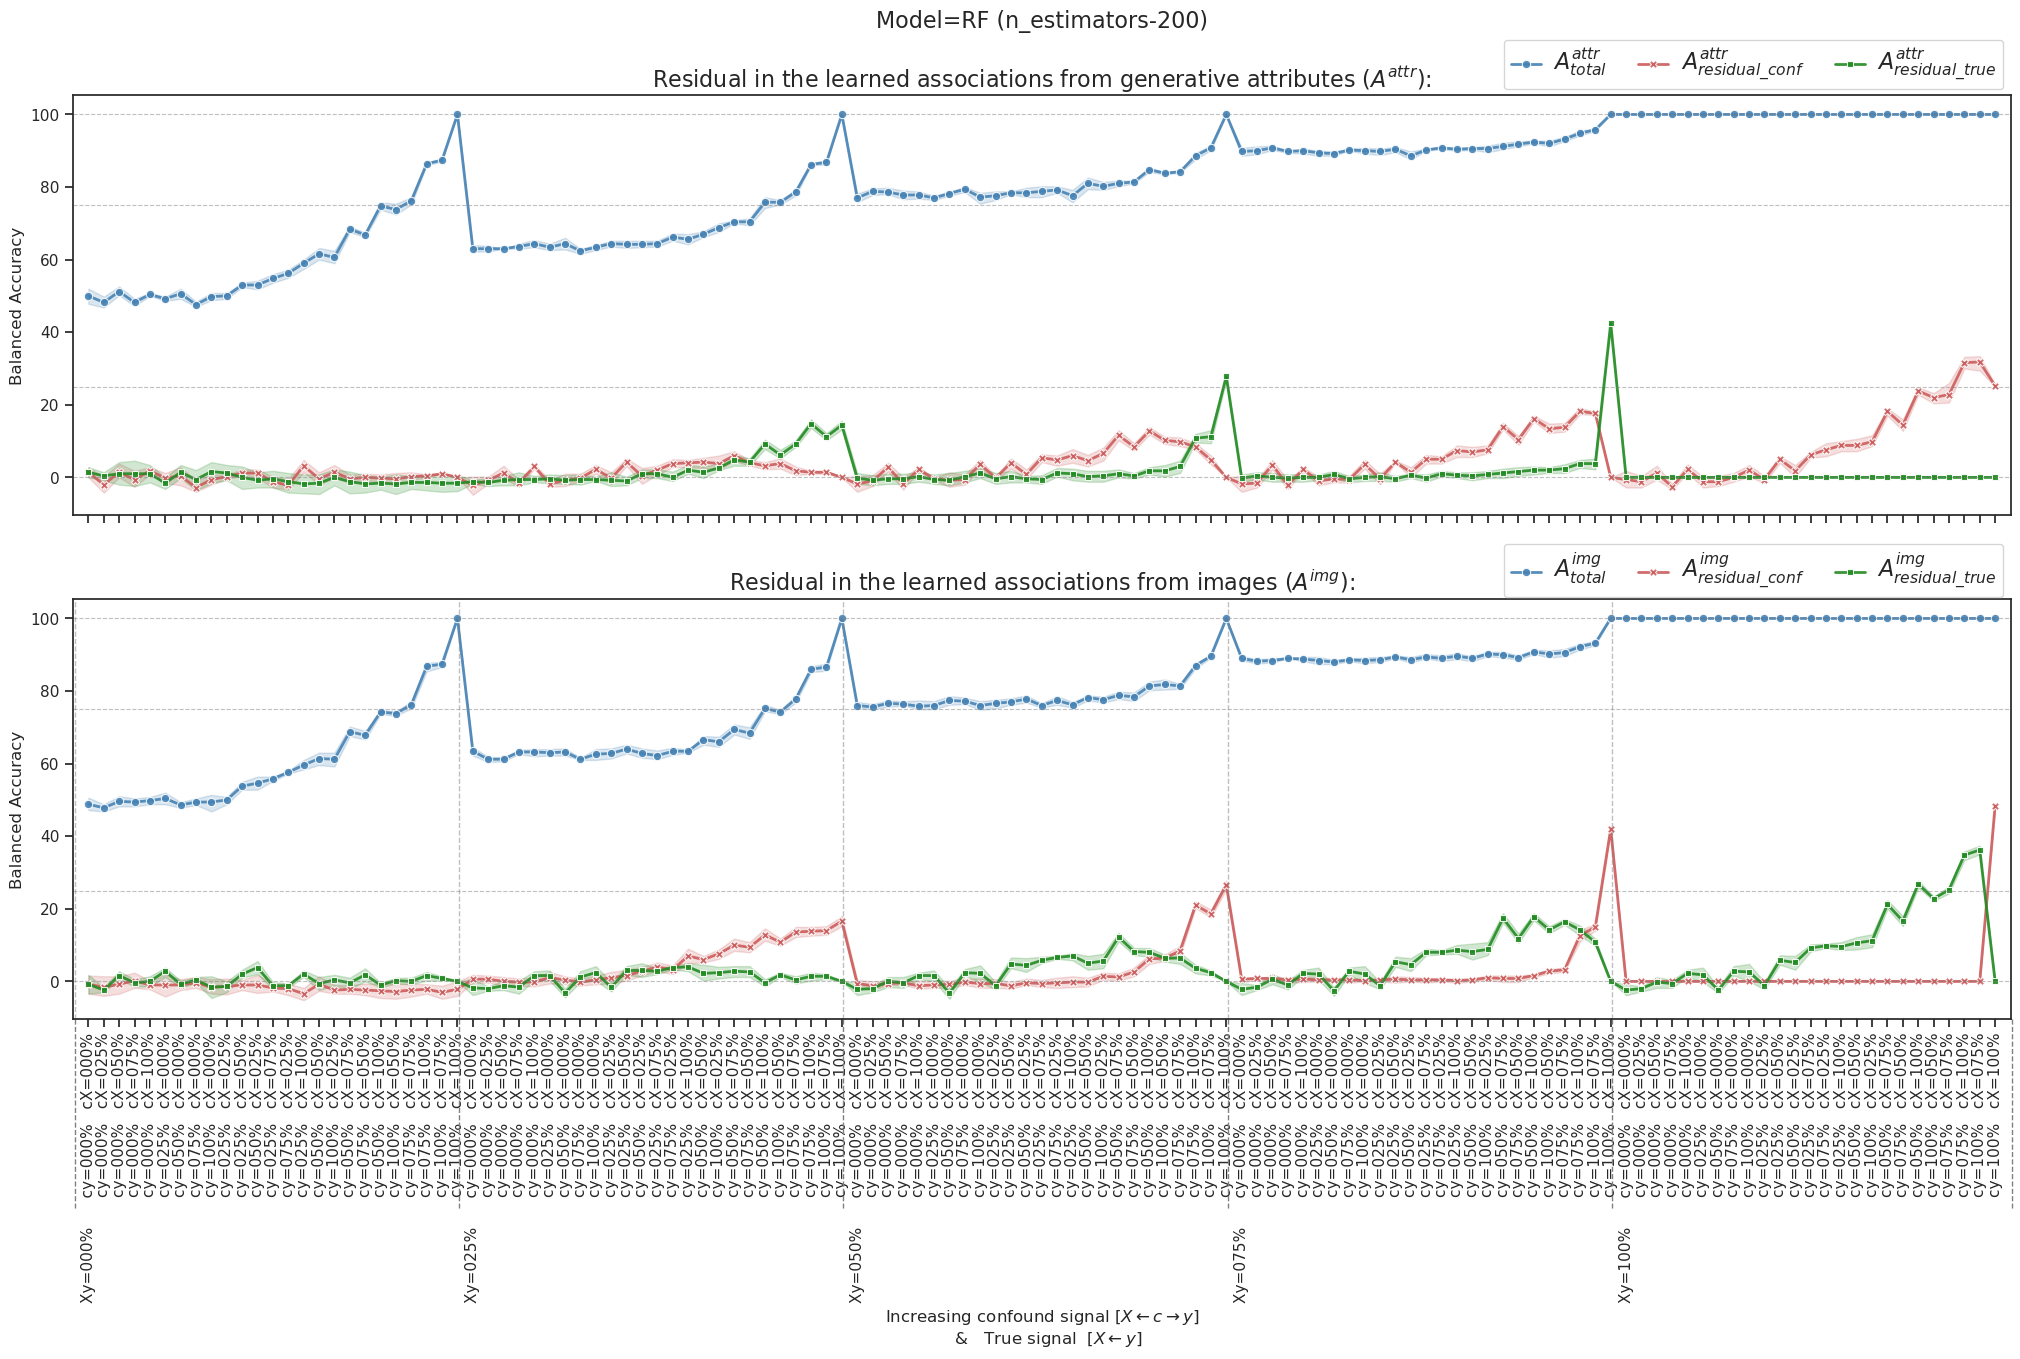

In [29]:
# plot the decomposed contributions or the remaining contributions
if PLOT_CONTRIB_DECOMPOSED:

    sns.set_theme(style="ticks")
    f, axes = plt.subplots(2, 1, figsize=(25, 12), sharex=True, sharey=True)
    axes = axes.flatten()

    ### 1) Plot A^{attr}
    df_decomp_plot = df_decomp.reset_index(level=["out", "inp", "trial"], drop=True)
    df_decomp_plot.index = df_decomp_plot.index.map(lambda x: x.split('_')[-1])  # remove the 'dataset' prefix

    # create 2 more columns '( conf & true ) - ( conf )' and '( conf & true ) - ( true )'
    df_decomp_plot = calc_residuals(df_decomp_plot)
    # display(df_decomp_plot.info())

    df_decomp_plot = df_decomp_plot.rename(columns={'conf & true':r'$A^{attr}_{total}$', 
                                                    '( conf & true ) - ( conf )':r'$A^{attr}_{residual\_true}$',  
                                                    '( conf & true ) - ( true )':r'$A^{attr}_{residual\_conf}$'}  
                                                    )
    # residual\_select the columns we want to plot and reorder columns so that Aconf is red and Atrue is green
    df_decomp_plot = df_decomp_plot[[r'$A^{attr}_{total}$', r'$A^{attr}_{residual\_conf}$', r'$A^{attr}_{residual\_true}$']]

    viz_contrib_table_2(df_decomp_plot, metric_name=metric_name, 
                        cmap={r'$A^{attr}_{total}$':'steelblue',
                              r'$A^{attr}_{residual\_conf}$':'indianred',
                              r'$A^{attr}_{residual\_true}$':'forestgreen'},
                              ax=axes[0], adjust_xticks=False,
                              title=f"Model={MODEL_NAME} ({MODEL_PARAMS})\n\n"+ r"Residual in the learned associations from generative attributes ($A^{attr}$):")
    

    ### 2) Plot A^{img}
    df_imgs_plot = df_imgs.reset_index(level=["out", "inp", "trial"], drop=True)
    df_imgs_plot.index = df_imgs_plot.index.map(lambda x: x.split('_')[-1])  # remove the 'dataset' prefix

    # create 2 more columns '( conf & true ) - ( conf )' and '( conf & true ) - ( true )'
    df_imgs_plot = calc_residuals(df_imgs_plot)
    # display(df_imgs_plot.info())

    df_imgs_plot = df_imgs_plot.rename(columns={'conf & true':r'$A^{img}_{total}$',
                                                '( conf & true ) - ( conf )':r'$A^{img}_{residual\_conf}$', 
                                                '( conf & true ) - ( true )':r'$A^{img}_{residual\_true}$'})
    # residual\_select the columns we want to plot and reorder columns so that Aconf is red and Atrue is green
    df_imgs_plot = df_imgs_plot[[r'$A^{img}_{total}$', r'$A^{img}_{residual\_conf}$', r'$A^{img}_{residual\_true}$']]
    viz_contrib_table_2(df_imgs_plot, metric_name=metric_name,
                        cmap={r'$A^{img}_{total}$':'steelblue',
                              r'$A^{img}_{residual\_conf}$':'indianred',
                              r'$A^{img}_{residual\_true}$':'forestgreen'},
                              ax=axes[1], adjust_xticks=True,
                              title=r"Residual in the learned associations from images ($A^{img}$):")
    
    if SAVE_FIGS:
        plt.savefig(f'figures/LA-resid_{MODEL_NAME}_{MODEL_PARAMS}_{metric_name}.png', bbox_inches='tight')

##### Extreme pure datasets
`Xy = 100%` and `Xcy = 100%`

In [ ]:
# if PLOT_CONTRIB_DECOMPOSED:
#     # plot the decomposed contributions
#     df_decomp = show_contrib_table(
#                    bl_results, 
#                    avg_over_trials=False,
#                    filter_rows={'out':['lbl_lesion'], 'inp':['attr_all']},
#                    filter_cols=[f'score_test_{metric_name}', 
#                                 f'score_test_no-conf-ext_{metric_name}', 
#                                 f'score_test_no-true-ext_{metric_name}']
#                                 )
    
#     df_decomp = df_decomp.data.rename(columns={f'score_test_{metric_name}':'conf & true',
#                                                f'score_test_no-conf-ext_{metric_name}':'true (ext)',
#                                                f'score_test_no-true-ext_{metric_name}':'conf (ext)'})
    
#     # if the r2 metric values are below 0 then set it to zero
#     if metric_name=='r2':
#         df_decomp[['conf & true', 'true (ext)', 'conf (ext)']] = df_decomp[['conf & true', 'true (ext)', 'conf (ext)']].map(lambda x: 0 if x<0 else x)
#     # display(df_decomp.style.bar( align='mid', color=['#d65f5f', '#5fba7d']))
        
#     df_decomp_plot = df_decomp.reset_index(level=["out", "inp", "trial"], drop=True)
#     df_decomp_plot.index = df_decomp_plot.index.map(lambda x: x.split('_')[-1])  # remove the 'dataset' prefix
#     df_decomp_plot = df_decomp_plot.rename(columns={'conf & true':r'$A^{attr}_{total}$', 
#                                                     'true (ext)':r'$A^{attr}_{true (ext)}$',  
#                                                     'conf (ext)':r'$A^{attr}_{conf (ext)}$'}  
#                                                     )
#     # reorder columns so that Aconf is red and Atrue is green
#     df_decomp_plot = df_decomp_plot[[r'$A^{attr}_{total}$', r'$A^{attr}_{conf (ext)}$', r'$A^{attr}_{true (ext)}$']]
#     viz_contrib_table_2(df_decomp_plot, metric_name=metric_name, cmap={r'$A^{attr}_{total}$':'steelblue',
#                                                                 r'$A^{attr}_{conf (ext)}$':'indianred',
#                                                                 r'$A^{attr}_{true (ext)}$':'forestgreen'},
#                         title=r"Learned associations from generative attributes ($A^{attr}$):" + f":\n estimated by validating on pure datasets\nModel={MODEL_NAME} ({MODEL_PARAMS})")
        
#     if SAVE_FIGS: plt.savefig(f'figures/LA-attr-ext_{MODEL_NAME}_{MODEL_PARAMS}_{metric_name}.png', 
#     bbox_inches='tight')
#     plt.show()

#### Compare with SHAP

All results are shown in percentage (%)


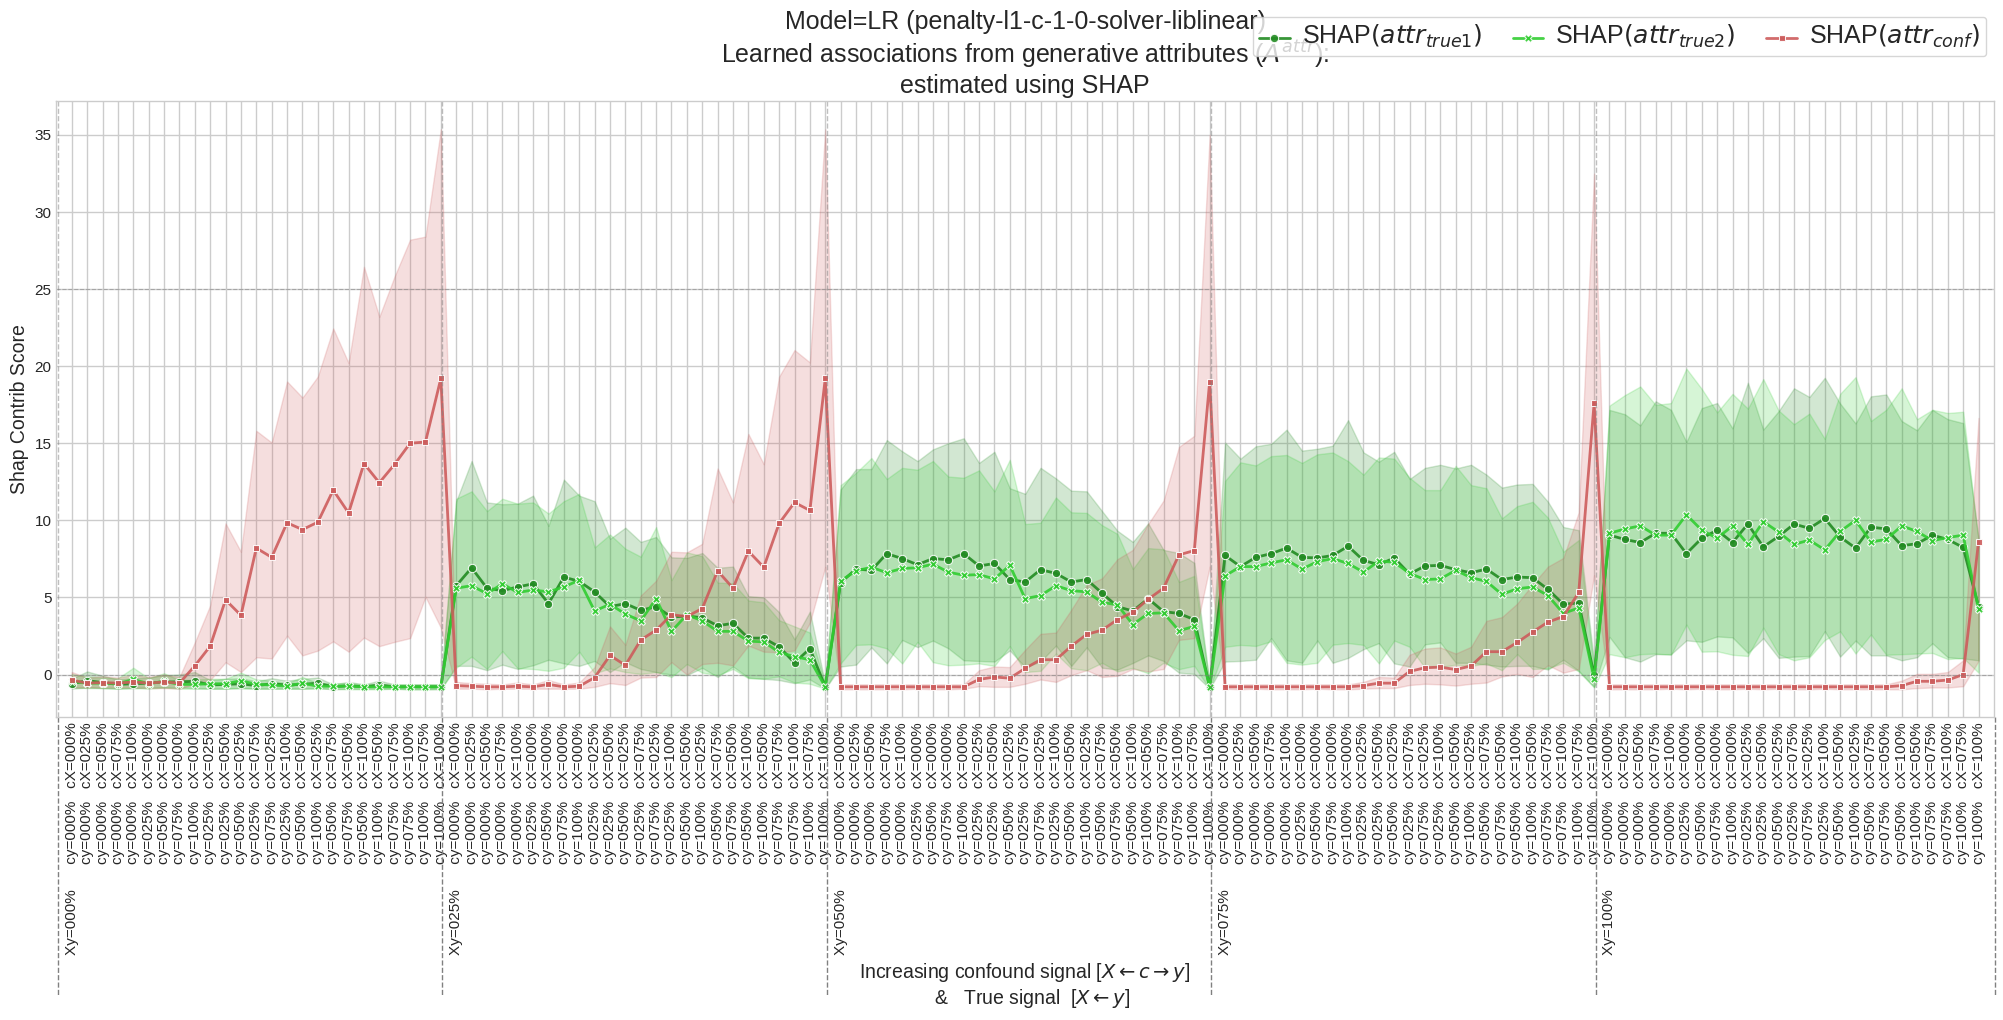

In [ ]:
# compare with the SHAP contrib scores if it is computed
if PLOT_CONTRIB_DECOMPOSED and ('shap__brain-int_fill' in bl_results[0].columns):
    df_shap_2 = show_contrib_table(
                bl_results, 
                avg_over_trials=False,
                filter_rows={'out':['lbl_lesion']}, 
                filter_cols=['shap__shape-midr_curv','shap__shape-midr_vol-rad', 
                             'shap__brain-int_fill'])
                
    df_shap_2 = df_shap_2.data.reset_index(level=["out", "inp", "trial"], drop=True)

    df_shap_2 = df_shap_2.rename(columns={'shap__brain-int_fill': r'SHAP$(attr_{conf})$', 
                                        'shap__shape-midr_curv':r'SHAP$(attr_{true 1})$', 
                                        'shap__shape-midr_vol-rad':r'SHAP$(attr_{true 2})$'})
    
    # display(df_shap_2.head())
    viz_contrib_table_2(df_shap_2, metric_name='SHAP contrib score', 
                        cmap={'SHAP$(attr_{conf})$':'indianred', 
                              'SHAP$(attr_{true 1})$':'forestgreen', 
                              'SHAP$(attr_{true 2})$':'limegreen'},
    title=f"Model={MODEL_NAME} ({MODEL_PARAMS})\n"+ r"Learned associations from generative attributes ($A^{attr}$):" + f"\nestimated using SHAP")
    
    if SAVE_FIGS: 
        plt.savefig(f'figures/CA-shap_{MODEL_NAME}_{MODEL_PARAMS}.png',
    bbox_inches='tight')

In [ ]:
from datetime import datetime
print("Notebook finished at", datetime.now().isoformat())        

Notebook finished at 2024-02-26T17:28:49.251762
